# Learn PPCA

In [2]:
import scipy.io as io
import matplotlib.pyplot as plt
import numpy as np


In [3]:
from ppca import PPCA

### Load the data from the Markdown

In [4]:
data = io.loadmat('tonnage.mat')

In [5]:
X = data['X']
y = data['y'][:,0]
np.moveaxis(X,0,1).shape

(4, 1201, 582)

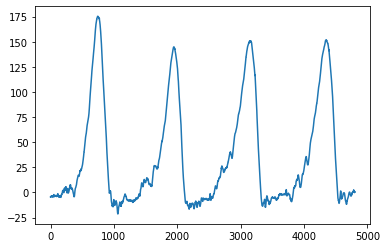

In [6]:
vx = np.moveaxis(X,0,1).reshape(-1,582).T
y[y==5]=2
plt.plot(vx[0,:])


In [7]:
vx[y==0]

array([[-4.48024  , -4.48024  , -4.59224  , ...,  0.621283 ,  0.532529 ,
         0.621283 ],
       [-7.39239  , -6.83236  , -6.72035  , ..., -0.976302 , -0.798793 ,
        -0.798793 ],
       [-7.5044   , -7.39239  , -7.39239  , ...,  0.0887548,  0.       ,
         0.       ],
       ...,
       [-6.38434  , -6.38434  , -6.60835  , ..., -3.28393  , -3.46144  ,
        -3.81646  ],
       [-8.40044  , -8.28844  , -8.28844  , ..., -3.90521  , -3.90521  ,
        -3.81646  ],
       [-6.38434  , -6.27233  , -6.16033  , ..., -2.57389  , -2.84015  ,
        -3.10642  ]])

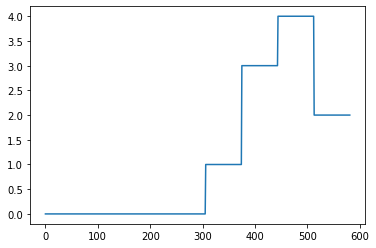

In [8]:
plt.plot(y)

In [9]:
from sklearn.decomposition import PCA

In [10]:
from ppca import PPCA

In [11]:
ppca = PPCA(svd_solver='auto', n_components=10)
ppca.fit(vx)

PPCA(copy=True, iterated_power='auto', n_components=10, random_state=None,
     svd_solver='auto', tol=0.0, whiten=None)

In [12]:
def create_sensing_matrix(p,index):
    p_obs = len(index);
    Z = np.zeros((p,p_obs));
    for ii,i in enumerate(index):
        Z[i,ii] = 1
    return Z

ppca.score_samples_index(vx,[50])
index = [50]
pa = len(index)
A = create_sensing_matrix(4804,index)
ppca.score_samples_A(vx,A)


array([-2.0789863 , -2.01973993, -1.99314948, -2.18302688, -1.89054135,
       -2.0789863 , -2.11164185, -1.96858178, -1.84486218, -1.83327138,
       -1.89054135, -1.86365661, -2.17209103, -1.9255164 , -1.89054135,
       -1.83183983, -2.21022654, -1.85324769, -1.90199379, -2.25038113,
       -1.94603876, -2.01175972, -1.88610925, -1.89054135, -2.70281218,
       -2.01973993, -1.89054135, -2.29256197, -1.86365661, -2.43123667,
       -1.91990242, -1.89054135, -1.90199379, -2.53379807, -1.84279324,
       -1.86365661, -1.84486218, -2.17209103, -1.9255164 , -1.86040639,
       -1.9255164 , -2.13598142, -1.8384986 , -1.91990242, -1.88610925,
       -2.11164185, -2.11164185, -1.98576264, -1.90701837, -2.11164185,
       -2.0789863 , -1.93983381, -1.84486218, -1.8384986 , -1.84486218,
       -1.84279324, -2.0483505 , -1.89054135, -1.87608829, -1.8384986 ,
       -1.96858178, -1.90701837, -1.90701837, -2.22174999, -1.94603876,
       -2.0789863 , -1.89054135, -1.89054135, -1.96858178, -1.98

In [13]:
pca = PCA(svd_solver='auto', n_components=10)
pca.fit(vx)
W = pca.components_.T
sigma = np.sqrt(pca.noise_variance_)


In [14]:
exp_var = pca.explained_variance_
exp_var_diff = np.maximum(exp_var - pca.noise_variance_, 0.)
precision = np.dot(W.T, W) / pca.noise_variance_
precision.flat[::len(precision) + 1] += 1. / exp_var_diff


In [15]:
def fast_logdet(A):
    """Compute log(det(A)) for A symmetric
    Equivalent to : np.log(nl.det(A)) but more robust.
    It returns -Inf if det(A) is non positive or is not defined.
    Parameters
    ----------
    A : array_like
        The matrix
    """
    sign, ld = np.linalg.slogdet(A)
    if not sign > 0:
        return -np.inf
    return ld


### Solution of PCA is given by
PCA solution is given by
$$X = U S V^T$$ where $V$ is the loading matrix (pca.component.T). 
The PPCA solution is givne by 
$$W = V(L-\sigma^2I)^{1/2}.$$
$L$ is diagonal matrix with eigen values of Sample covariance and $\sigma$ is the noise;

see book  [PRML](https://www.microsoft.com/en-us/research/uploads/prod/2006/01/Bishop-Pattern-Recognition-and-Machine-Learning-2006.pdf) (12.45)

In [16]:
exp_var = pca.explained_variance_
exp_var_diff = np.maximum(exp_var - pca.noise_variance_, 0.)
W=pca.components_.T.dot(np.diag(np.sqrt(exp_var_diff)))

Use [matrix inverse lemma](https://en.wikipedia.org/wiki/Woodbury_matrix_identity) to compute the inverse of $$C^{-1} = (WW' + \sigma^2 I)^{-1} = \sigma^{-2} I -  \sigma^{-2} W ( W'W + \sigma^{2}I)^{-1} W'  $$
see book [PRML](https://www.microsoft.com/en-us/research/uploads/prod/2006/01/Bishop-Pattern-Recognition-and-Machine-Learning-2006.pdf) Eq. (12.40)

In [17]:
def get_precision(W,sigma):
    # Use the transformed W
    p = W.shape[0]
    n = W.shape[1]
    M = W.T@W + sigma**2*np.eye(n)
    precision = 1/sigma**2 * np.eye(p)- 1/sigma**2*W@np.linalg.solve(M,W.T)
    return precision


see book [PRML](https://www.microsoft.com/en-us/research/uploads/prod/2006/01/Bishop-Pattern-Recognition-and-Machine-Learning-2006.pdf) Eq. (12.44)

In [18]:
def loglk(X,mean,precision):
    log_like = 0
    Xr = X - mean
    p = len(mean)
    log_like = -.5 * (Xr * (np.dot(Xr, precision))).sum(axis=1)
    log_like -= .5 * (p * np.log(2. * np.pi) -
                      fast_logdet(precision))
    return log_like

In [19]:
precision = get_precision(W,sigma)

loglk(vx,pca.mean_,precision)

array([-8764.88786251, -8857.43474087, -8862.07978988, -8687.6073816 ,
       -8630.40393607, -8855.86357252, -8497.78687502, -8751.85148853,
       -8529.62827182, -8490.32650053, -8514.12699275, -8618.11077628,
       -8431.30761777, -8385.13289709, -8398.22454522, -8368.80429395,
       -8428.00621074, -8433.45416372, -8297.81864068, -8459.96317063,
       -8387.18688517, -8340.15094758, -8438.65446192, -8450.39774934,
       -8343.28383636, -8349.13021444, -8473.79659992, -8403.74336003,
       -8357.57607239, -8494.79206258, -8507.88606747, -8346.66509883,
       -8323.36665752, -8372.20988199, -8356.98919114, -8409.49234533,
       -8430.4396728 , -8379.41960737, -8417.699159  , -8467.23409406,
       -8352.71530929, -8355.95624998, -8396.71583163, -8389.60480811,
       -8360.46989228, -8517.03878587, -8449.33329442, -8293.40894546,
       -8358.14504264, -8464.75438041, -8475.46854917, -8427.62464908,
       -8476.83091791, -8333.11521738, -8334.63862816, -8297.37630687,
      

In [20]:
np.mean(pca.score_samples(vx))

-8370.668072221288

Select columns from $W$

In [21]:
def create_sensing_matrix(p,index):
    p_obs = len(index);
    Z = np.zeros((p,p_obs));
    for ii,i in enumerate(index):
        Z[i,ii] = 1
    return Z


### Created Selected Sampling in index matrix

In [22]:
index = [50]
pa = len(index)
A = create_sensing_matrix(4804,index)
Wa = (A.T@W)
precision = get_precision(Wa,sigma)
mean = pca.mean_[index]
xa = (A.T@vx[1,:].T).reshape(1,pa)
np.mean(loglk(xa,mean,precision))

-2.019741692022098